# SIT220 – Data Wrangling  
## Task 4 – Working with pandas Data Frames (Heterogeneous Data)

**Student:** Barbara Rein Peralta Calma

**ID:** s224712709

**email:** s224712709@deakin.edu.au

**undergraduate**

#### This notebook works with three datasets containing Myki touch-on and touch-off transactions, along with detailed tram stop information, for the 20 busiest tram routes in Melbourne in 2017. The datasets include the touch-on records, touch-off records, and a separate file with stop-level details such as stop IDs, names, and location information. Using pandas and seaborn, the aim is to link each touch-on and touch-off event with its corresponding stop details and then explore several aspects of tram usage. The analysis looks at the busiest stops, the tram routes with the highest average passenger activity, and the routes with the longest average travel times. All data are loaded once at the start, and the remaining steps are carried out within a single notebook.


#### The three datasets are loaded into pandas data frames: scan_on for touch-on transactions, scan_off for touch-off transactions, and stops for the tram stop metadata. The stops file does not include a header row, so the column names are assigned manually using the details provided in the unit. These data frames are then used throughout the analysis.

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

scan_on = pd.read_csv("myki_2017_top20_tram_routes_ScanOnTransaction.csv")
scan_off = pd.read_csv("myki_2017_top20_tram_routes_ScanOffTransaction.csv")

stops = pd.read_csv(
    "stop_locations.txt",
    sep="|",
    header=None,
    names=[
        "stop_id",
        "StopNameShort",
        "StopNameLong",
        "StopType",
        "Locality",
        "Postcode",
        "State",
        "LGA",
        "Region",
        "Latitude",
        "Longitude",
    ],
)

print("Scan-on shape :", scan_on.shape)
print("Scan-off shape:", scan_off.shape)
print("Stops shape   :", stops.shape)
print("Scan-on columns:", scan_on.columns.tolist())


Scan-on shape : (1904721, 9)
Scan-off shape: (611293, 9)
Stops shape   : (27614, 11)
Scan-on columns: ['mode', 'business_date', 'card_id', 'card_type', 'vehicle_id', 'parent_route', 'route_id', 'stop_id', 'date_time']


#### Q1: To bring the datasets together, I started by matching the touch-on records with the touch-off records so each trip has both sides of the transaction. I renamed the stop and time columns in both files so I could easily tell which values were from the touch-on and which were from the touch-off. The trip identifiers (mode, business date, card ID, vehicle ID, route info, etc.) were used as the merge keys so the right records line up.

#### I used a left merge because I wanted to keep every touch-on, even if the passenger didn’t touch off. After that, I joined the stop information twice—once for the touch-on stop and once for the touch-off stop, so each trip would have the long stop names and stop numbers added in. The stop number is just taken directly from the stop ID.

#### In the end, the trips data frame shows every touch-on with its matching touch-off details (when available), plus the stop names for both ends of the journey. This gives a complete view of each recorded trip.

In [15]:
# rename stop/time columns in both transaction tables
scan_on_renamed = scan_on.rename(
    columns={
        "stop_id": "stop_id_on",
        "date_time": "date_time_on",
    }
)
scan_off_renamed = scan_off.rename(
    columns={
        "stop_id": "stop_id_off",
        "date_time": "date_time_off",
    }
)

# key columns that identify the same trip in both tables
key_cols = [
    "mode",
    "business_date",
    "card_id",
    "card_type",
    "vehicle_id",
    "parent_route",
    "route_id",
]

# merge touch-on with touch-off using a left join
trips = pd.merge(
    scan_on_renamed,
    scan_off_renamed[key_cols + ["stop_id_off", "date_time_off"]],
    on=key_cols,
    how="left",
)

# basic subset of stops information
stops_basic = stops[["stop_id", "StopNameLong"]]

# join touch-on stop details
trips = trips.merge(
    stops_basic,
    left_on="stop_id_on",
    right_on="stop_id",
    how="left",
)
trips = trips.rename(columns={"StopNameLong": "StopNameLong_on"})
trips = trips.drop(columns=["stop_id"])

# join touch-off stop details
trips = trips.merge(
    stops_basic,
    left_on="stop_id_off",
    right_on="stop_id",
    how="left",
)
trips = trips.rename(columns={"StopNameLong": "StopNameLong_off"})
trips = trips.drop(columns=["stop_id"])

# create stop number fields, using stop IDs directly
trips["StopNumber_on"] = trips["stop_id_on"]
trips["StopNumber_off"] = trips["stop_id_off"]

print("Combined trips shape:", trips.shape)
trips.head()

Combined trips shape: (1908065, 15)


,mode,business_date,card_id,card_type,vehicle_id,parent_route,route_id,stop_id_on,date_time_on,stop_id_off,date_time_off,StopNameLong_on,StopNameLong_off,StopNumber_on,StopNumber_off
0,3,2017-02-15,7639560,1,638,59,16852,19256,2017-02-15 08:57:13,NaN,NaN,19-Royal Childrens Hospital/Flemington Rd (Nor...,NaN,19256,NaN
1,3,2017-11-09,15240980,1,593,86,24655,6103,2017-11-09 12:30:33,NaN,NaN,42-Dundas St/Plenty Rd (Preston),NaN,6103,NaN
2,3,2017-02-15,4672220,1,753,3,16911,19499,2017-02-15 19:58:34,NaN,NaN,13-Federation Square/Swanston St (Melbourne City),NaN,19499,NaN
3,3,2017-09-08,21058700,2,1095,109,15234,17910,2017-09-08 21:37:27,NaN,NaN,5-Elizabeth St/Collins St (Melbourne City),NaN,17910,NaN
4,3,2017-02-22,18491770,9,488,59,1452,19609,2017-02-22 08:14:26,NaN,NaN,34-Moonee Valley Civic Centre/Pascoe Vale Rd (...,NaN,19609,NaN


#### Q2: To find the busiest stops, I looked only at the touch-on data, since a touch-on basically represents someone starting a trip. I first made sure the business_date column was treated as an actual date so it was easier to group by day. After that, I counted how many touch-ons happened at each stop for each day of the year.

#### Once I had the daily counts, I worked out the average number of touch-ons per day for every stop. I then joined this with the stop information so the results included the proper long stop names, not just the IDs. From there, I picked the top 10 stops with the highest average daily touch-ons and plotted them in a horizontal bar chart. The plot makes it clear which stops consistently have the most passenger activity throughout 2017.

Top 10 busiest stops (average daily touch-ons):
      stop_id                                       StopNameLong  \
1279    19696       1-Melbourne University/Swanston St (Carlton)   
346     17877  1-Flinders Street Railway Station/Elizabeth St...   
1196    19499  13-Federation Square/Swanston St (Melbourne City)   
1190    19491             3-Lincoln Square/Swanston St (Carlton)   
1274    19689  8-Melbourne Central Station/Swanston St (Melbo...   
1308    19725        129-Beacon Cove/Light Rail (Port Melbourne)   
1054    19338               139-Glenferrie Rd/Toorak Rd (Toorak)   
1360    19781       58-Box Hill Central/Whitehorse Rd (Box Hill)   
1188    19482        59-Airport West/Matthews Ave (Airport West)   
1194    19497  10-Bourke Street Mall/Swanston St (Melbourne C...   

      avg_touchons_per_day  
1279            173.474394  
346             128.847411  
1196            114.439353  
1190            100.235135  
1274             94.824798  
1308             86.152738  


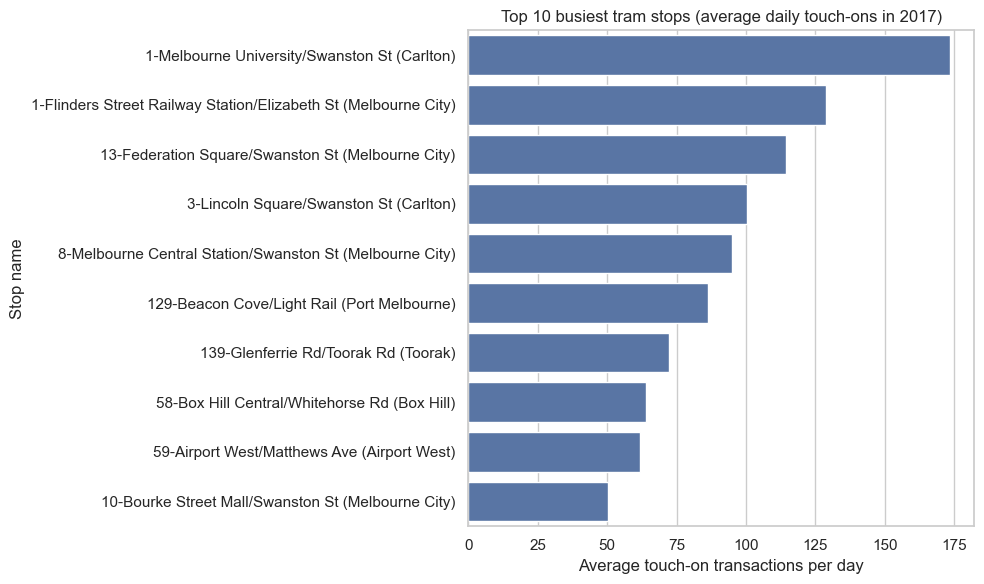

In [16]:
# ensure business_date is treated as a date
scan_on_dates = scan_on.copy()
scan_on_dates["business_date"] = pd.to_datetime(scan_on_dates["business_date"]).dt.date

# daily counts per stop
daily_counts = (
    scan_on_dates
    .groupby(["stop_id", "business_date"])
    .size()
    .reset_index(name="touch_on_count")
)

# average daily touch-ons per stop
avg_daily_by_stop = (
    daily_counts
    .groupby("stop_id", as_index=False)["touch_on_count"]
    .mean()
    .rename(columns={"touch_on_count": "avg_touchons_per_day"})
)

# attach stop names
avg_daily_by_stop = avg_daily_by_stop.merge(
    stops_basic,
    left_on="stop_id",
    right_on="stop_id",
    how="left",
)

# top 10 busiest stops
top10_stops = avg_daily_by_stop.sort_values(
    "avg_touchons_per_day",
    ascending=False
).head(10)

print("Top 10 busiest stops (average daily touch-ons):")
print(top10_stops[["stop_id", "StopNameLong", "avg_touchons_per_day"]])

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_stops,
    x="avg_touchons_per_day",
    y="StopNameLong",
)
plt.xlabel("Average touch-on transactions per day")
plt.ylabel("Stop name")
plt.title("Top 10 busiest tram stops (average daily touch-ons in 2017)")
plt.tight_layout()
plt.show()


#### Q3: For this part, I focused on the touch-on data again, but this time looking at passenger activity by tram route instead of by stop. Since each touch-on counts as someone boarding a tram on a specific route, I grouped the data by route_id and by day to see how many passengers each route handled on each date.

#### Once the daily counts were calculated, I averaged them across the whole year so each route had a single value representing its typical daily passenger load. After sorting these averages, I took the top 10 routes and plotted them in a bar chart. The plot makes it easy to see which tram routes consistently carry the most passengers throughout 2017.

Top 10 busiest tram routes (average passengers per day):
      route_id  avg_passengers_per_day
1061     31467              298.752137
207      16588              275.353712
979      30929              268.316239
19        1455              259.133333
638      19670              231.105263
474      17872              211.896104
863      24515              207.231343
997      30968              206.526316
526      18479              204.586207
971      24688              189.724138


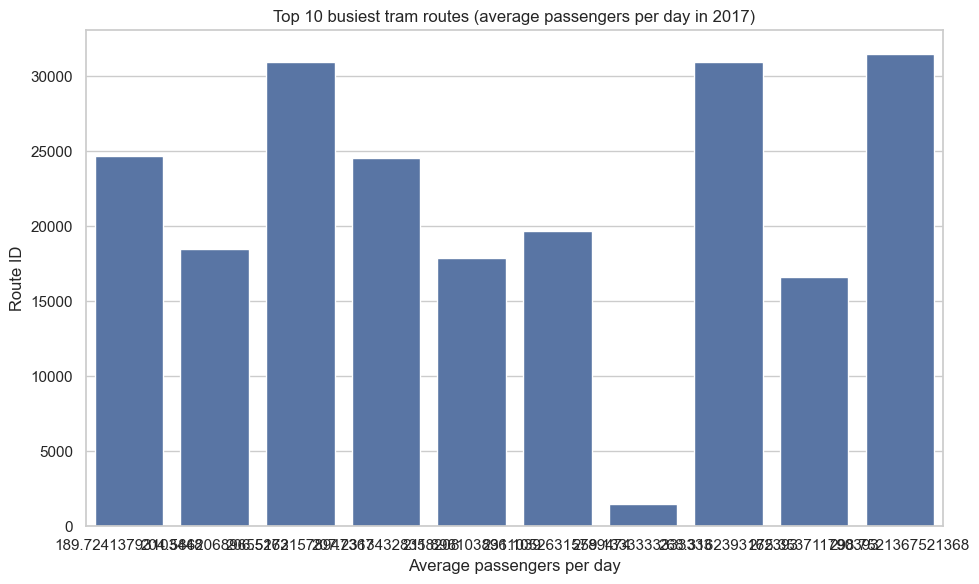

In [17]:
# daily passenger counts per route
daily_route_counts = (
    scan_on_dates
    .groupby(["route_id", "business_date"])
    .size()
    .reset_index(name="passenger_count")
)

avg_daily_by_route = (
    daily_route_counts
    .groupby("route_id", as_index=False)["passenger_count"]
    .mean()
    .rename(columns={"passenger_count": "avg_passengers_per_day"})
)

top10_routes = avg_daily_by_route.sort_values(
    "avg_passengers_per_day",
    ascending=False
).head(10)

print("Top 10 busiest tram routes (average passengers per day):")
print(top10_routes)

# convert route_id to string so seaborn treats it as categorical (prevents overlapping labels)
top10_routes_plot = top10_routes.copy()
top10_routes_plot["route_id"] = top10_routes_plot["route_id"].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_routes_plot,
    x="avg_passengers_per_day",
    y="route_id",
)
plt.xlabel("Average passengers per day")
plt.ylabel("Route ID")
plt.title("Top 10 busiest tram routes (average passengers per day in 2017)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Q4: This part looks at the average end-to-end travel time for each tram route. The travel time for a trip is simply the difference between the touch-off and touch-on timestamps. To work with these values properly, I first converted the date_time_on and date_time_off columns into pandas datetime objects.

#### Only trips with both timestamps were kept, since missing touch-off times make the duration impossible to calculate. For every completed trip, I worked out the duration in minutes and then grouped the results by route_id to find the mean travel time for each route. After sorting these averages from longest to shortest, I selected the top 10 routes and visualised them with a horizontal bar plot.

#### The final ranking shows which tram routes tend to have the longest average journeys across all the recorded trips.

Top 10 longest tram routes (average trip duration in minutes):
     route_id  avg_duration_minutes
354     17671            110.916667
749     24606            101.320833
673     24226             96.700000
674     24230             96.666667
130     15651             92.200000
493     19144             82.583333
752     24610             78.100000
77      15398             73.291667
662     24181             71.733333
143     15769             68.806667


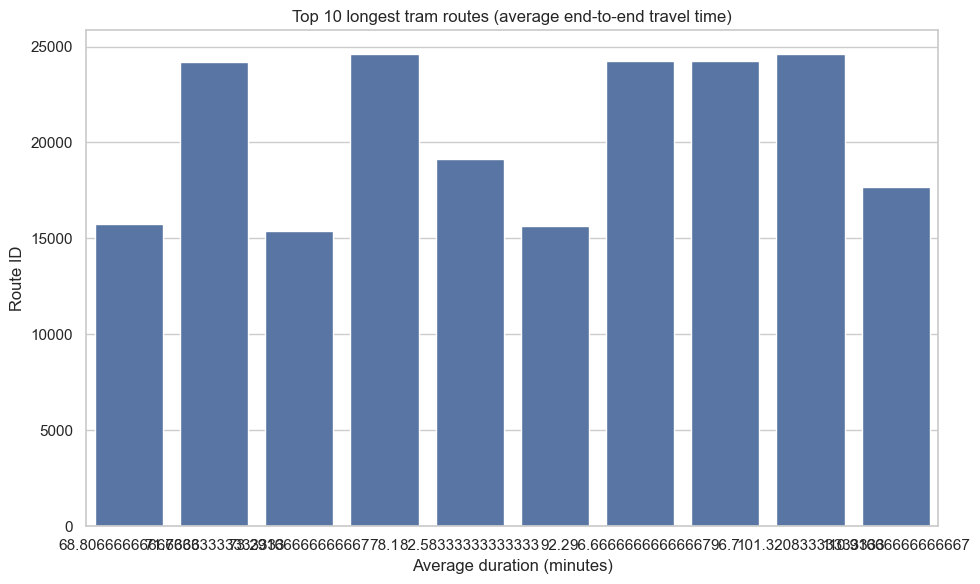

In [18]:
trips_times = trips.copy()
trips_times["date_time_on"] = pd.to_datetime(trips_times["date_time_on"])
trips_times["date_time_off"] = pd.to_datetime(trips_times["date_time_off"])

# keep only trips with a valid touch-off time
completed_trips = trips_times.dropna(subset=["date_time_off"]).copy()

# compute duration in minutes
completed_trips["duration_minutes"] = (
    (completed_trips["date_time_off"] - completed_trips["date_time_on"])
    .dt.total_seconds() / 60.0
)

# average duration per route
avg_duration_by_route = (
    completed_trips
    .groupby("route_id", as_index=False)["duration_minutes"]
    .mean()
    .rename(columns={"duration_minutes": "avg_duration_minutes"})
)

top10_longest_routes = avg_duration_by_route.sort_values(
    "avg_duration_minutes",
    ascending=False
).head(10)

print("Top 10 longest tram routes (average trip duration in minutes):")
print(top10_longest_routes)

# convert route_id to string so seaborn treats it as categorical (prevents overlapping labels)
top10_longest_routes_plot = top10_longest_routes.copy()
top10_longest_routes_plot["route_id"] = top10_longest_routes_plot["route_id"].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_longest_routes_plot,
    x="avg_duration_minutes",
    y="route_id",
)
plt.xlabel("Average duration (minutes)")
plt.ylabel("Route ID")
plt.title("Top 10 longest tram routes (average end-to-end travel time)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
